## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

print (train_files[0:5])

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

#print (dog_names)

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


['dogImages/train\\095.Kuvasz\\Kuvasz_06442.jpg'
 'dogImages/train\\057.Dalmatian\\Dalmatian_04054.jpg'
 'dogImages/train\\088.Irish_water_spaniel\\Irish_water_spaniel_06014.jpg'
 'dogImages/train\\008.American_staffordshire_terrier\\American_staffordshire_terrier_00596.jpg'
 'dogImages/train\\008.American_staffordshire_terrier\\American_staffordshire_terrier_00563.jpg']
There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
#random.shuffle(human_files)

print (human_files[0:3])

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

['lfw\\Aaron_Eckhart\\Aaron_Eckhart_0001.jpg'
 'lfw\\Aaron_Guiel\\Aaron_Guiel_0001.jpg'
 'lfw\\Aaron_Patterson\\Aaron_Patterson_0001.jpg']
There are 13236 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


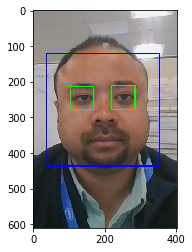

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# extract pre-trained eye detector
eye_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_eye.xml')


# load color (BGR) image
img = cv2.imread(human_files[9])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)


# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face

'''
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
'''
    
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)


    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

human_cnt = 0
dog_hm_cnt = 0

for img in human_files_short:
    if face_detector(img):
        human_cnt += 1

for img in dog_files_short:
    if face_detector(img):
        dog_hm_cnt += 1
        
print ('percentage of the first 100 images in human_files have a detected human face', str(float(human_cnt))+'%')
print ('percentage of the first 100 images in dog_files have a detected human face', str(float(dog_hm_cnt))+'%')
        
        

percentage of the first 100 images in human_files have a detected human face 96.0%
percentage of the first 100 images in dog_files have a detected human face 12.0%


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
import os
proxy = 'http://proxy-chain.intel.com:911'
proxy1 = 'https://proxy-chain.intel.com:912'
os.environ['http_proxy'] = proxy 
os.environ['https_proxy'] = proxy1 

from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [7]:
from keras.preprocessing import image                  
#from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [8]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [10]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.


human_count = 0    
for img in human_files_short:
    isDog = dog_detector(img)
    if isDog:
        human_count += 1
    percentage = (human_count/len(human_files_short)) * 100
print('Percentage of humans misclassified as dogs:: {}%'.format(percentage))

dog_count = 0
for img in dog_files_short:
    isDog = dog_detector(img)
    if isDog:
        dog_count += 1
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs correctly classified as dogs: {}%'.format(percentage))


Percentage of humans misclassified as dogs:: 1.0%
Percentage of dogs correctly classified as dogs: 100.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True    

#print (train_files[0:5])

human_files = np.array(glob("lfw/*/*"))

#sorted(glob(img_paths))

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors)

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

In [ ]:
#print (train_tensors[0:5])

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ 

In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

model = Sequential()
#os.environ['CUDA_VISIBLE_DEVICES']='0'

### TODO: Define your architecture.

model.add(BatchNormalization(input_shape=(224, 224, 3)))
model.add(Conv2D(filters=16, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=32, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=64, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=3, kernel_initializer='he_normal', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())

model.add(GlobalAveragePooling2D())

#model.add(Dense(1024, activation="relu"))

model.add(Dense(133, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 54, 54, 32)        128       
__________

### Compile the Model

In [22]:
from keras import optimizers
#sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer='adam' ,metrics=['accuracy'])


### Image Augmentation

In [17]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen.fit(train_tensors)

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [23]:
from keras.callbacks import ModelCheckpoint  
import tensorflow as tf

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 80

batch_size = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)


#Assigning GPU 0 for training the model

os.environ['CUDA_VISIBLE_DEVICES']='0'

with tf.device('/gpu:0'):

### Using Image Augmentation
    model.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=batch_size),
                    validation_data=(valid_tensors, valid_targets), 
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, callbacks=[checkpointer], verbose=1)

Epoch 1/80
334/334 [==============================] - 53s 160ms/step - loss: 4.5479 - acc: 0.0484 - val_loss: 4.4209 - val_acc: 0.0587

Epoch 00001: val_loss improved from inf to 4.42095, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/80
334/334 [==============================] - 54s 163ms/step - loss: 4.1203 - acc: 0.0873 - val_loss: 4.0337 - val_acc: 0.0874

Epoch 00002: val_loss improved from 4.42095 to 4.03368, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/80
334/334 [==============================] - 55s 165ms/step - loss: 3.8294 - acc: 0.1201 - val_loss: 3.9418 - val_acc: 0.0898

Epoch 00003: val_loss improved from 4.03368 to 3.94181, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/80
334/334 [==============================] - 57s 171ms/step - loss: 3.5441 - acc: 0.1612 - val_loss: 3.6065 - val_acc: 0.1521

Epoch 00004: val_loss improved from 3.94181 to 3.60648, saving model to saved_models/weights.best.from_scratch.h

334/334 [==============================] - 56s 169ms/step - loss: 0.2988 - acc: 0.9172 - val_loss: 2.4842 - val_acc: 0.4563

Epoch 00039: val_loss did not improve from 1.99854
Epoch 40/80
334/334 [==============================] - 54s 162ms/step - loss: 0.2955 - acc: 0.9165 - val_loss: 2.4293 - val_acc: 0.4754

Epoch 00040: val_loss did not improve from 1.99854
Epoch 41/80
334/334 [==============================] - 54s 163ms/step - loss: 0.2868 - acc: 0.9201 - val_loss: 2.3294 - val_acc: 0.4814

Epoch 00041: val_loss did not improve from 1.99854
Epoch 42/80
334/334 [==============================] - 57s 169ms/step - loss: 0.2736 - acc: 0.9189 - val_loss: 2.1861 - val_acc: 0.5006

Epoch 00042: val_loss did not improve from 1.99854
Epoch 43/80
334/334 [==============================] - 57s 170ms/step - loss: 0.2454 - acc: 0.9323 - val_loss: 2.2216 - val_acc: 0.4934

Epoch 00043: val_loss did not improve from 1.99854
Epoch 44/80
334/334 [==============================] - 57s 169ms/step - 

KeyboardInterrupt: 

# Training Keras Application Inception resnet 50

In [31]:
from keras.applications import resnet50, vgg16, vgg19, densenet, inception_v3, mobilenet, mobilenetv2, nasnet, inception_resnet_v2
from keras.models import Model
from keras.layers import Input
import tensorflow as tf 
import gc
gc.collect()

def model_keras(input_shape):
    
   
    base_model = inception_resnet_v2.InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(224,224,3), pooling=None)
    
    # Add a few layers at the end
    
    x = base_model.output
    x = Flatten()(x) # Flatten
    predictions = Dense(133, activation='softmax')(x) # Apply sigmoid
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

#preprocess the data

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

train_tensors = paths_to_tensor(train_files).astype('float32')
valid_tensors = paths_to_tensor(valid_files).astype('float32')
test_tensors = paths_to_tensor(test_files).astype('float32')

train_tensors = inception_resnet_v2.preprocess_input(train_tensors)
valid_tensors = inception_resnet_v2.preprocess_input(valid_tensors)

model_keras = model_keras(train_tensors.shape[1:])

#set sgn optimizer

sgd = optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

#compile the model

model_keras.compile(loss='categorical_crossentropy', optimizer=sgd ,metrics=['accuracy'])

#Assigning GPU 0 for training the model

os.environ['CUDA_VISIBLE_DEVICES']='0'


#Fitting the augmented image generator


with tf.device('/gpu:0'):

    datagen = image.ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True, vertical_flip=True)

    datagen.fit(train_tensors)
    

filepath="saved_models/inceptionresnet_v2_weights.best.from_scratch.hdf5"
checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only='True')
    
#training the model with real time augmentation of the images
with tf.device('/gpu:0'):

    
    model_keras.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=8), steps_per_epoch=len(train_tensors) / 8, epochs=30, validation_data=(valid_tensors, valid_targets),callbacks=[checkpointer])
    
    #Modelmobilenet.fit(train_files, train_targets, batch_size=8, epochs=35, validation_data=(valid_files, valid_targets),callbacks=[checkpointer])
del datagen


Epoch 1/30
835/835 [==============================] - 264s 316ms/step - loss: 3.7315 - acc: 0.2049 - val_loss: 2.8694 - val_acc: 0.5437

Epoch 00001: val_loss improved from inf to 2.86940, saving model to saved_models/inceptionresnet_v2_weights.best.from_scratch.hdf5
Epoch 2/30
835/835 [==============================] - 236s 282ms/step - loss: 2.1495 - acc: 0.4427 - val_loss: 1.7894 - val_acc: 0.6575

Epoch 00002: val_loss improved from 2.86940 to 1.78936, saving model to saved_models/inceptionresnet_v2_weights.best.from_scratch.hdf5
Epoch 3/30
835/835 [==============================] - 237s 283ms/step - loss: 1.6548 - acc: 0.5437 - val_loss: 1.9075 - val_acc: 0.6527

Epoch 00003: val_loss did not improve from 1.78936
Epoch 4/30
835/835 [==============================] - 236s 283ms/step - loss: 1.4270 - acc: 0.6003 - val_loss: 1.6686 - val_acc: 0.6802

Epoch 00004: val_loss improved from 1.78936 to 1.66857, saving model to saved_models/inceptionresnet_v2_weights.best.from_scratch.hdf5


### Training for few more interations

In [32]:
os.environ['CUDA_VISIBLE_DEVICES']='0'


#Fitting the augmented image generator


with tf.device('/gpu:0'):

    datagen = image.ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True,rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True, vertical_flip=True)

    datagen.fit(train_tensors)
    
with tf.device('/gpu:0'):

    
    model_keras.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=8), steps_per_epoch=len(train_tensors) / 8, epochs=10, validation_data=(valid_tensors, valid_targets),callbacks=[checkpointer])
    
    #Modelmobilenet.fit(train_files, train_targets, batch_size=8, epochs=35, validation_data=(valid_files, valid_targets),callbacks=[checkpointer])


Epoch 1/10
835/835 [==============================] - 236s 282ms/step - loss: 0.2508 - acc: 0.9211 - val_loss: 1.5991 - val_acc: 0.7557

Epoch 00001: val_loss did not improve from 1.55700
Epoch 2/10
835/835 [==============================] - 237s 284ms/step - loss: 0.2348 - acc: 0.9246 - val_loss: 1.8540 - val_acc: 0.7401

Epoch 00002: val_loss did not improve from 1.55700
Epoch 3/10
835/835 [==============================] - 237s 284ms/step - loss: 0.2271 - acc: 0.9298 - val_loss: 1.9255 - val_acc: 0.7389

Epoch 00003: val_loss did not improve from 1.55700
Epoch 4/10
835/835 [==============================] - 237s 284ms/step - loss: 0.2148 - acc: 0.9301 - val_loss: 2.1362 - val_acc: 0.7114

Epoch 00004: val_loss did not improve from 1.55700
Epoch 5/10
835/835 [==============================] - 237s 283ms/step - loss: 0.2054 - acc: 0.9331 - val_loss: 2.0174 - val_acc: 0.7186

Epoch 00005: val_loss did not improve from 1.55700
Epoch 6/10
835/835 [==============================] - 235s 2

In [33]:
with tf.device('/gpu:0'):

    
    model_keras.fit_generator(datagen.flow(train_tensors, train_targets, batch_size=8), steps_per_epoch=len(train_tensors) / 8, epochs=20, validation_data=(valid_tensors, valid_targets),callbacks=[checkpointer])
    

Epoch 1/20
835/835 [==============================] - 235s 282ms/step - loss: 0.1664 - acc: 0.9481 - val_loss: 1.7976 - val_acc: 0.7317

Epoch 00001: val_loss did not improve from 1.50141
Epoch 2/20
835/835 [==============================] - 233s 279ms/step - loss: 0.1715 - acc: 0.9446 - val_loss: 1.5560 - val_acc: 0.7509

Epoch 00002: val_loss did not improve from 1.50141
Epoch 3/20
835/835 [==============================] - 231s 277ms/step - loss: 0.1502 - acc: 0.9543 - val_loss: 1.7925 - val_acc: 0.7329

Epoch 00003: val_loss did not improve from 1.50141
Epoch 4/20
835/835 [==============================] - 232s 278ms/step - loss: 0.1556 - acc: 0.9494 - val_loss: 1.4228 - val_acc: 0.7689

Epoch 00004: val_loss improved from 1.50141 to 1.42278, saving model to saved_models/inceptionresnet_v2_weights.best.from_scratch.hdf5
Epoch 5/20
835/835 [==============================] - 236s 283ms/step - loss: 0.1593 - acc: 0.9528 - val_loss: 1.6836 - val_acc: 0.7401

Epoch 00005: val_loss did n

### Load the Model with the Best Validation Loss

In [38]:
from keras.models import load_model
model_keras.load_weights('saved_models/inceptionresnet_v2_weights.best.from_scratch.hdf5')
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Inception resnet v2 Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [41]:
#test_tensors = inception_resnet_v2.preprocess_input(test_tensors)

# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model_keras.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 78.3493%


### Testing the original model

In [42]:
# get index of predicted dog breed for each image in test set
test_files, test_targets = load_dataset('dogImages/test')
test_tensors = paths_to_tensor(test_files).astype('float32')/255

dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 47.4880%


# Result: Inception restnet Model absolutely wins:
Inception Resnet V2 Accuracy: 78.35%
Oriiginal model accuracy:     47.488%



### Function to plot Confusion matrix

In [43]:
#Plotting confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Evaluation on test dataset for Inception Restnet V2

836/836 [==============================] - 9s 11ms/step
Loss for Inception Restnet V2 = 1.326035086618086
Test Accuracy for Inception Restnet V2 = 0.7834928229665071


M:\Partha\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score = 0.04959456331282339
Recall score = 0.06937799043062201
[56, 58, 114, 18, 67, 20, 42, 51, 96, 50, 1, 18, 74, 132, 70, 13, 122, 31, 90, 41, 97, 68, 55, 94, 35, 124, 18, 18]
[56, 56, 5, 56, 54, 35, 30, 51, 0, 16, 56, 30, 56, 30, 56, 54, 122, 56, 90, 35, 35, 56, 43, 54, 30, 56, 30, 56]
---Confusion matrix ---

Confusion matrix, without normalization

Evaluation on test dataset for Original Model:

836/836 [==============================] - 2s 3ms/step
Loss for Inception Restnet V2 = 2.0370138655438947
Test Accuracy for Inception Restnet V2 = 0.4748803827751196


M:\Partha\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1 Score = 0.46680437930004076
Recall score = 0.4748803827751196
[56, 58, 114, 18, 67, 20, 42, 51, 96, 50, 1, 18, 74, 132, 70, 13, 122, 31, 90, 41, 97, 68, 55, 94, 35, 124, 18, 18]
[56, 47, 45, 38, 25, 91, 42, 51, 130, 50, 61, 18, 61, 37, 83, 47, 122, 31, 90, 74, 97, 80, 29, 18, 86, 71, 18, 18]
---Confusion matrix ---

Confusion matrix, without normalization


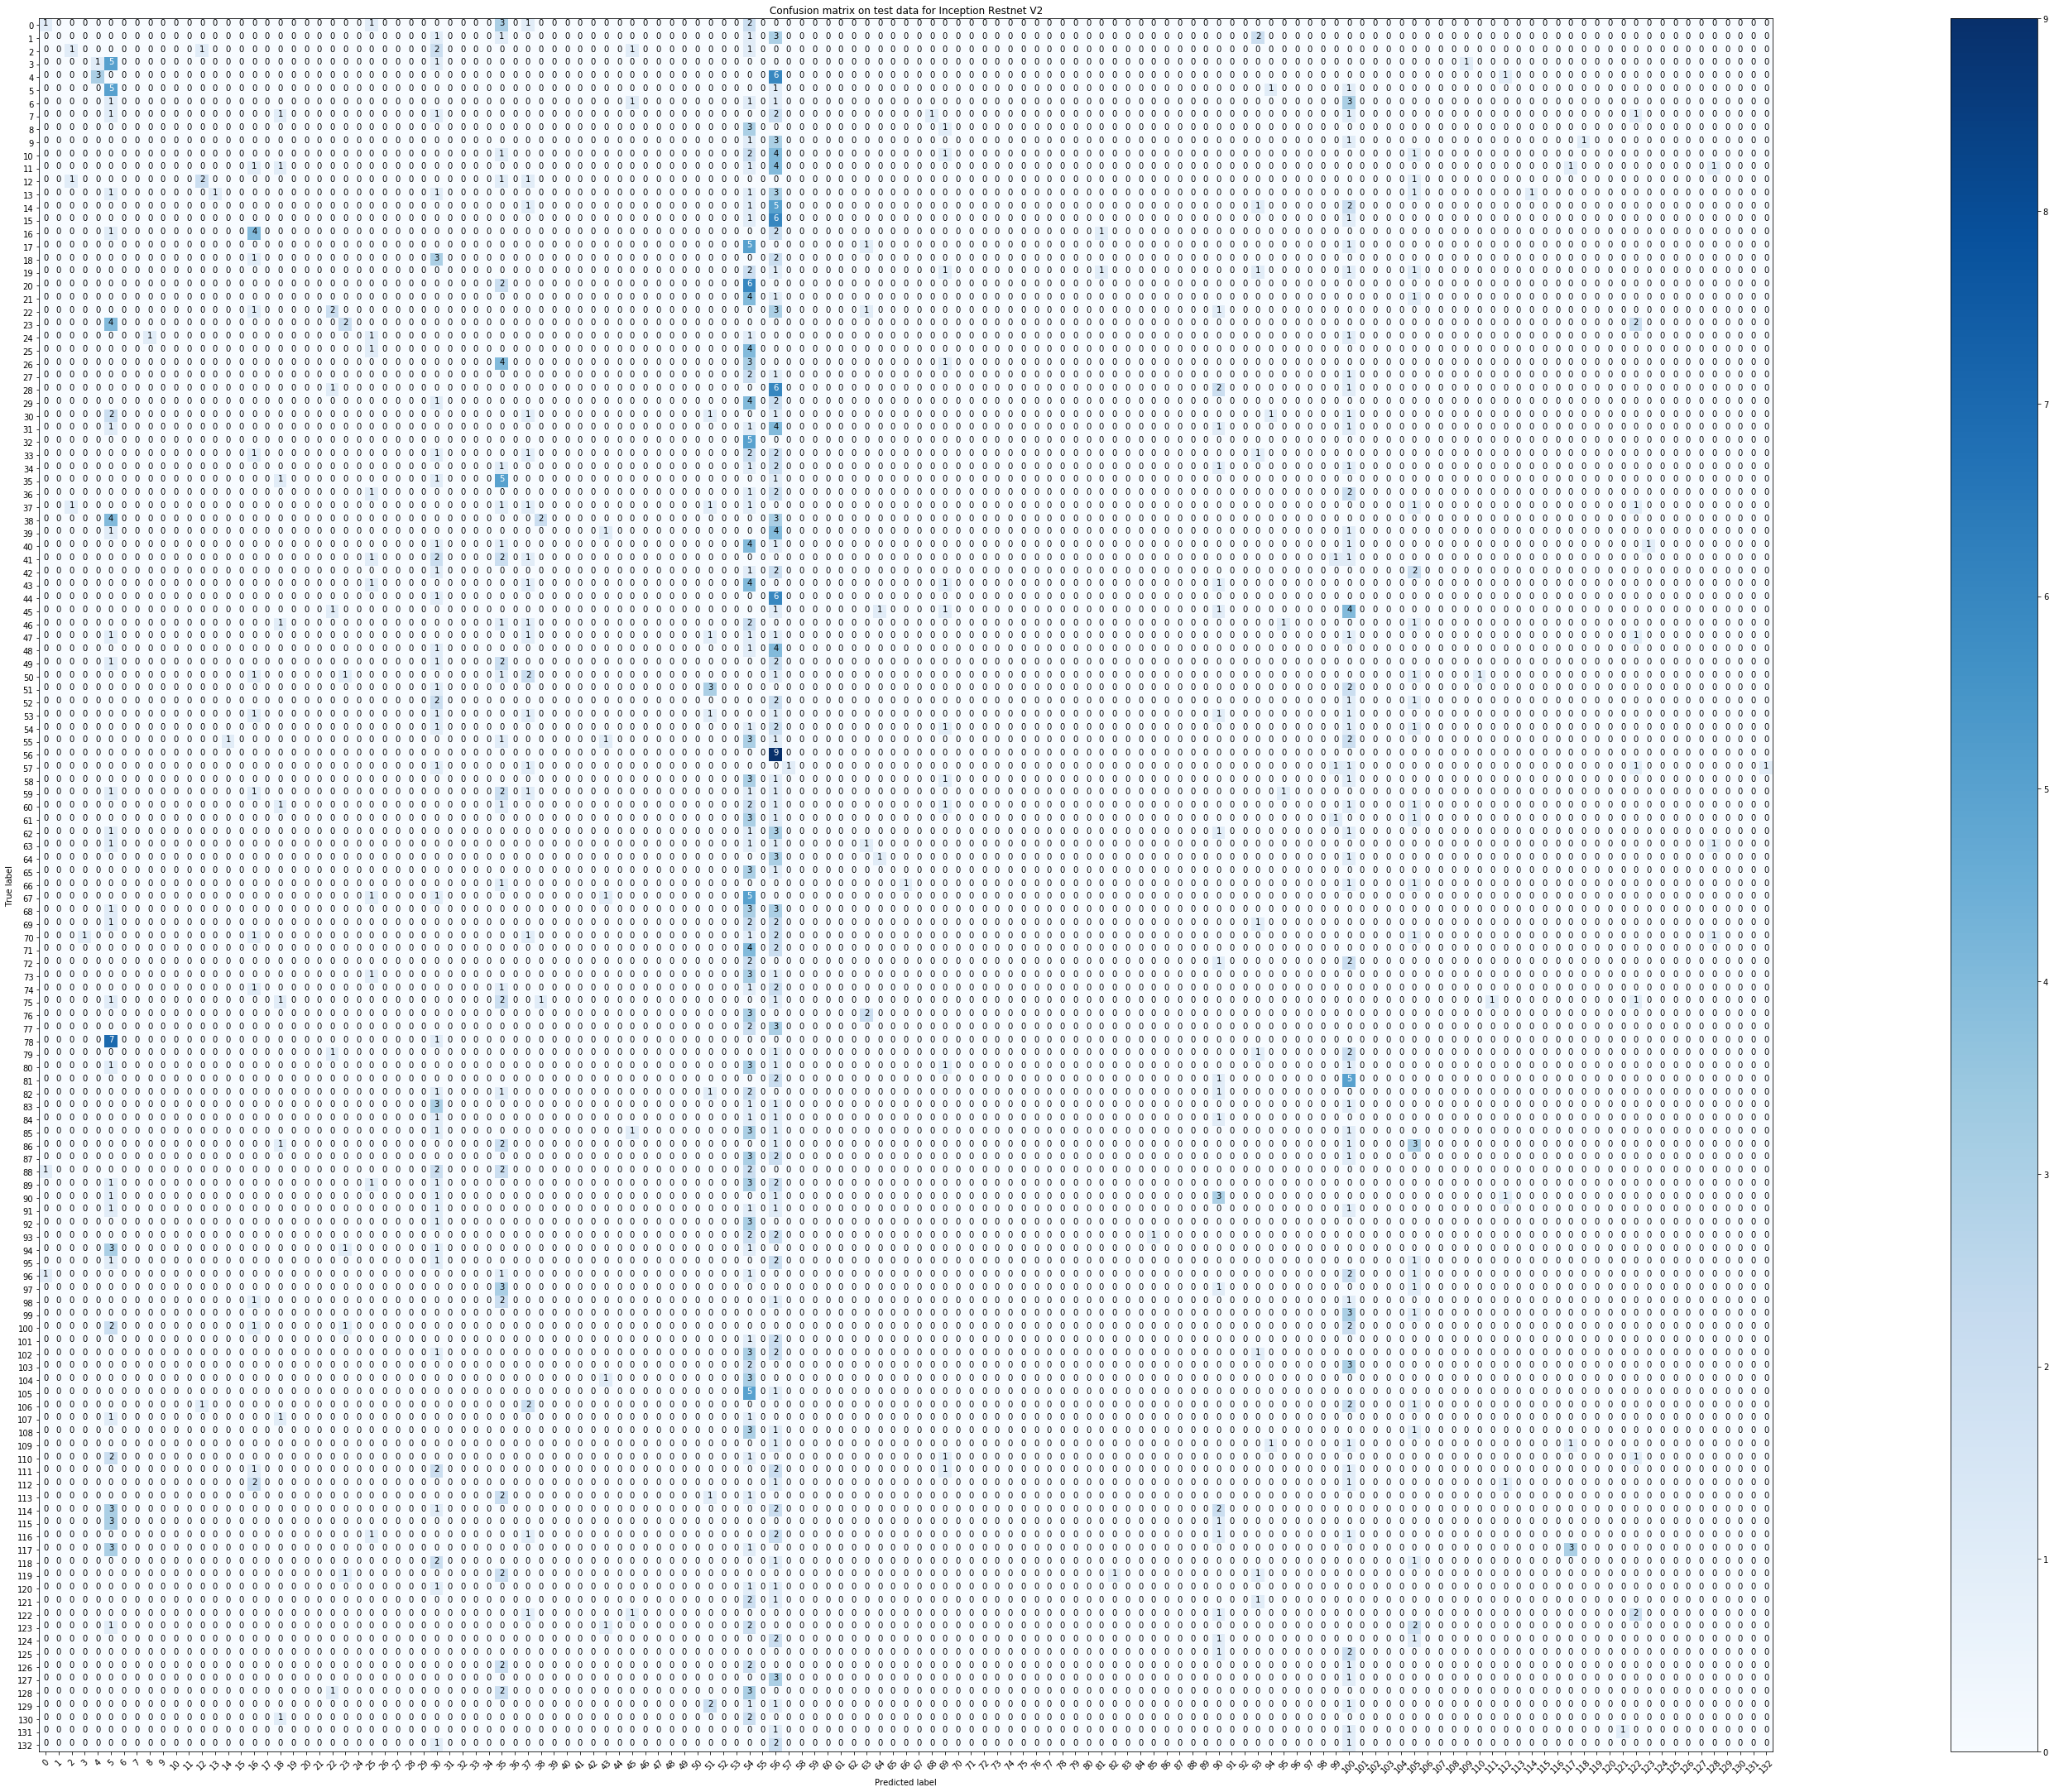

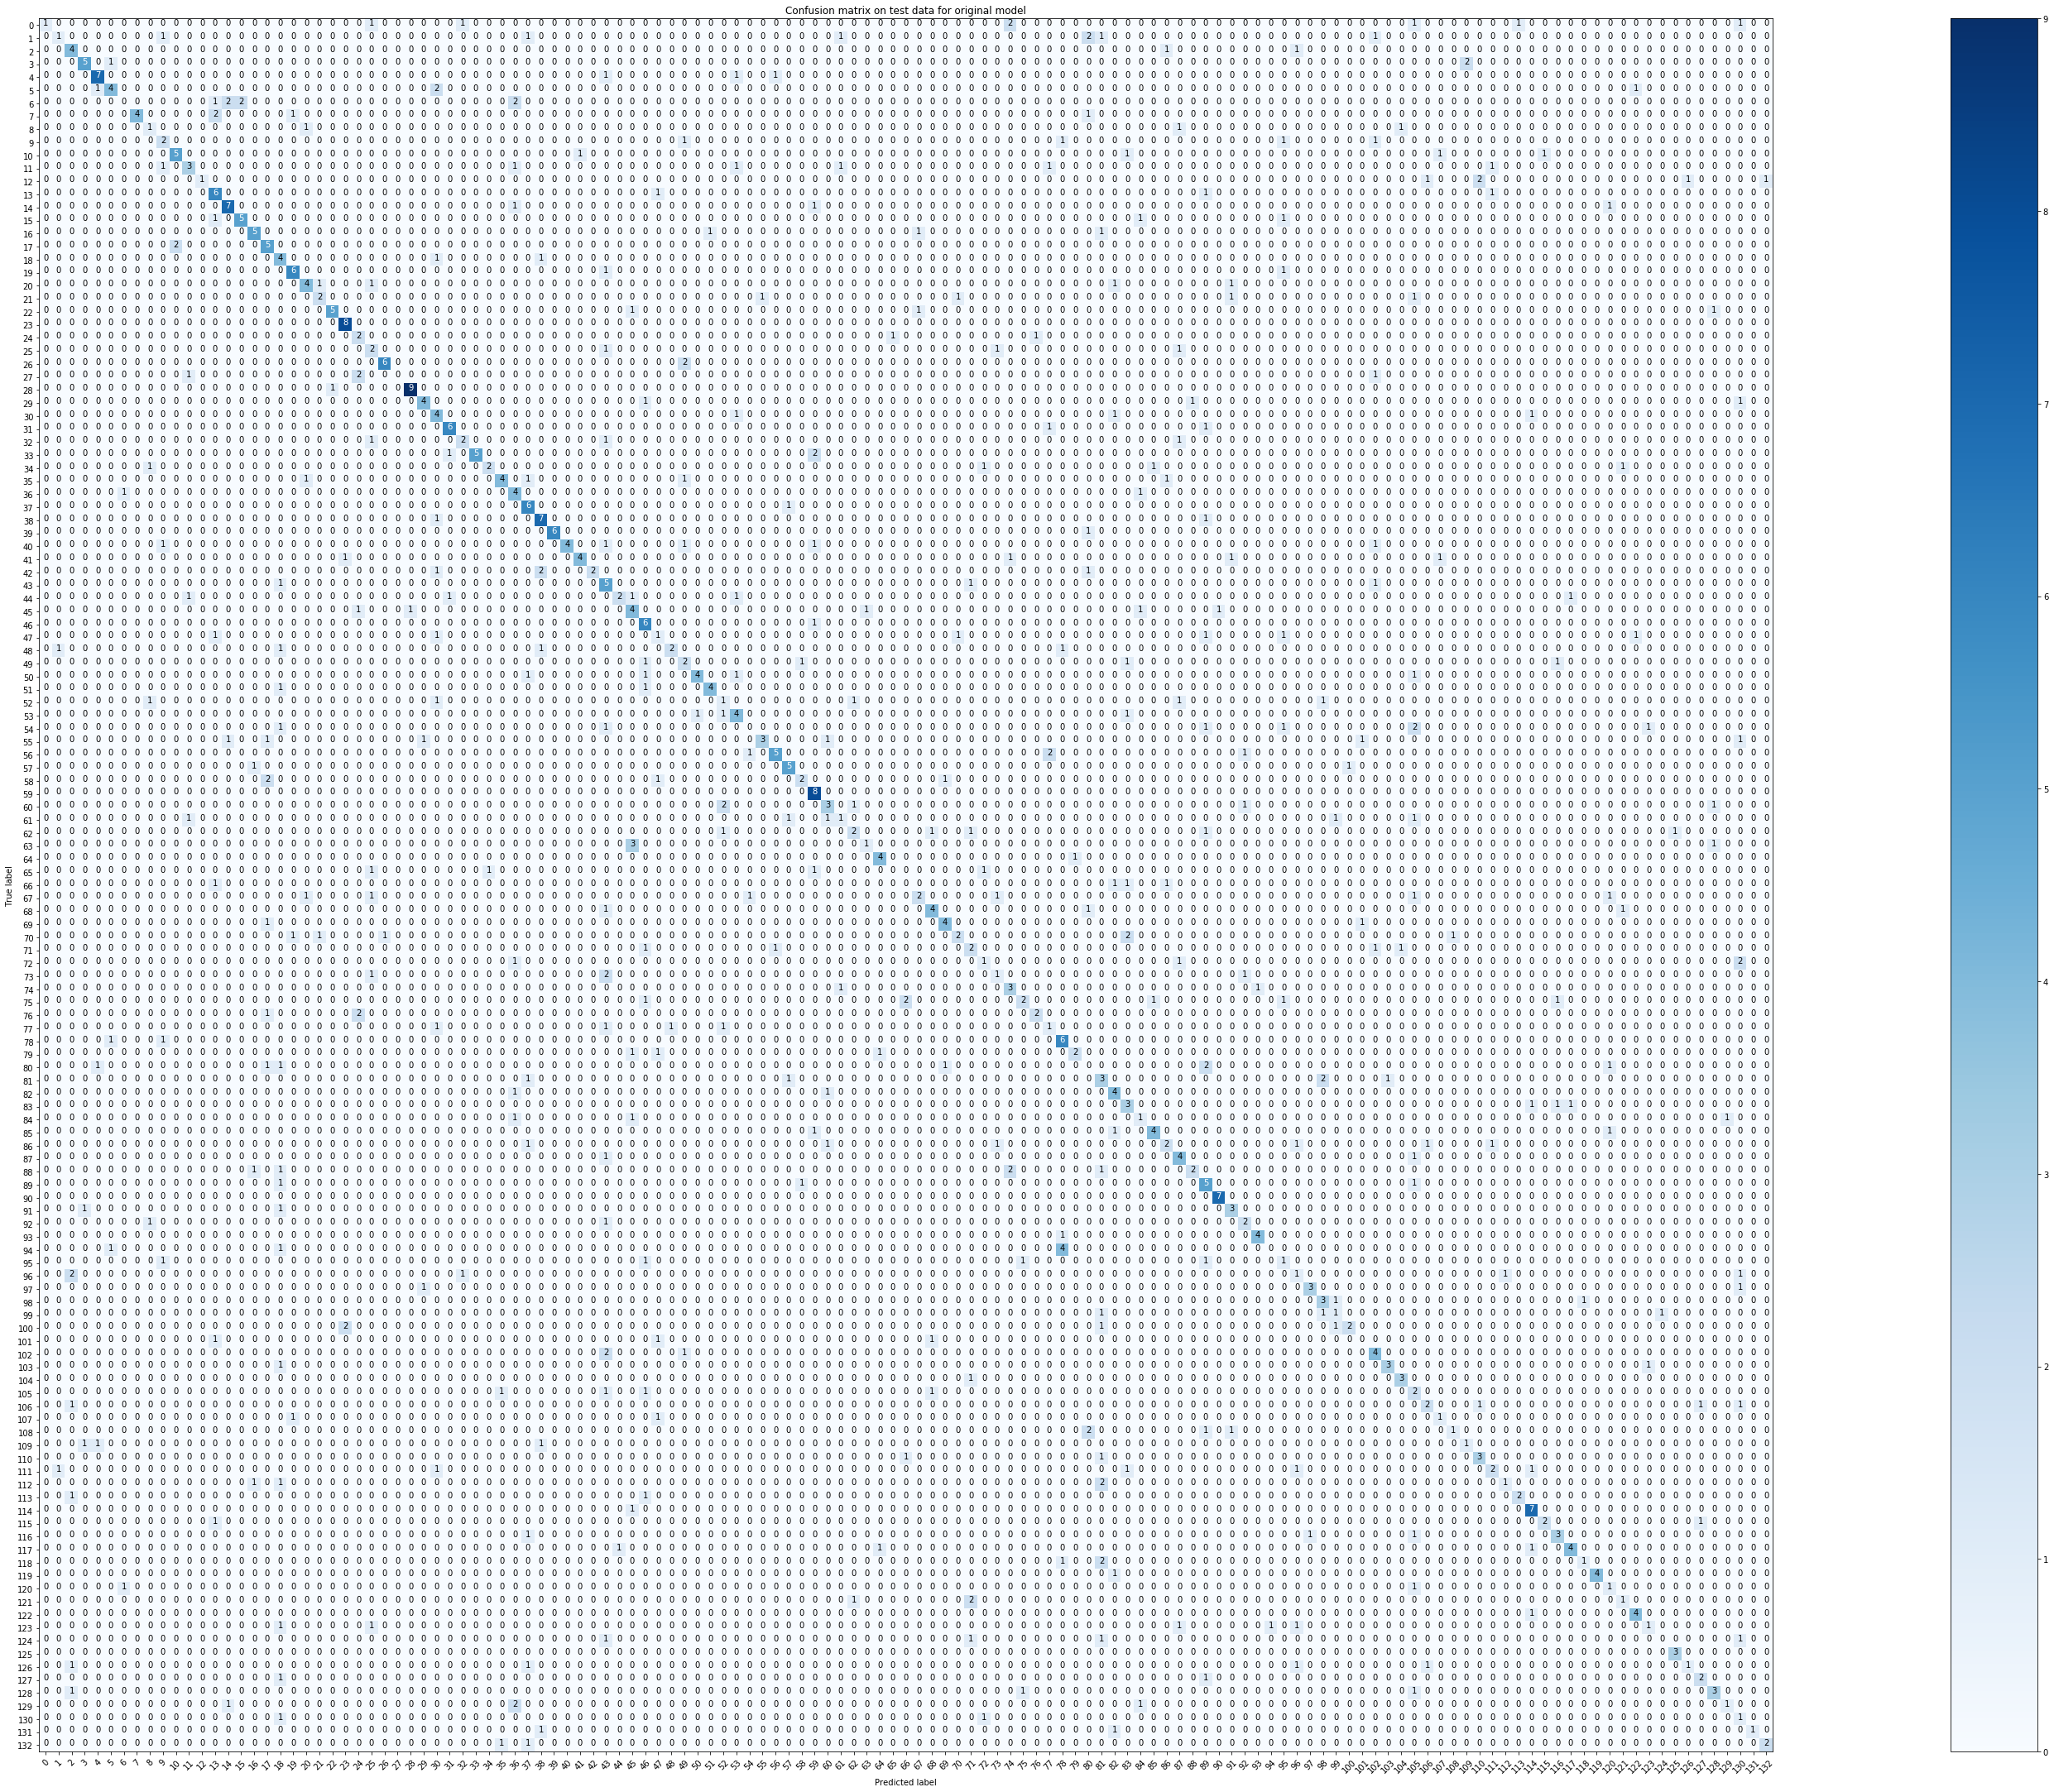

In [54]:
#Evaluating the model of Validation dataset
import os
import pylab as pl
from sklearn.metrics import roc_curve, auc, roc_auc_score, f1_score, recall_score, confusion_matrix
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import itertools
from IPython.display import Image

list_u = range(0, 133)
print ('Evaluation on test dataset for Inception Restnet V2')
print ()

test_files, test_targets = load_dataset('dogImages/test')
test_tensors = paths_to_tensor(test_files).astype('float32')
test_tensors = inception_resnet_v2.preprocess_input(test_tensors)


#preds = model.evaluate_generator(datagen.flow(X_val, Y_val, batch_size=8))

preds = model_keras.evaluate(test_tensors, test_targets, batch_size=8)
print ("Loss for Inception Restnet V2 = " + str(preds[0]))
print ("Test Accuracy for Inception Restnet V2 = " + str(preds[1]))


y_pred = model.predict(test_tensors)

#Converting back the one-hot encoded categorical vector to Integer indexes

Y_val_int = [ np.argmax(t) for t in test_targets]
y_pred_int = [ np.argmax(t) for t in y_pred]

#f1 , Recall

f1 = f1_score(Y_val_int, y_pred_int, average='weighted')
Re = recall_score(Y_val_int,y_pred_int, average='weighted')
print ("F1 Score = " + str(f1))
print ("Recall score = " + str(Re))

print (Y_val_int[0:28])
print (y_pred_int[0:28])

#Confusion matrix

confm = confusion_matrix(Y_val_int,y_pred_int)
print ("---Confusion matrix ---")
print ()


#Draw Confusion matrix

plt.figure(figsize=(60,30)) 
plot_confusion_matrix(confm, classes=list_u,
                      title='Confusion matrix on test data for Inception Restnet V2')
plt.savefig('InceptionRestnetV2.png')



print ()

print('Evaluation on test dataset for Original Model:')
print ()


test_files, test_targets = load_dataset('dogImages/test')
test_tensors = paths_to_tensor(test_files).astype('float32')/255


#preds = model.evaluate_generator(datagen.flow(X_val, Y_val, batch_size=8))

preds = model.evaluate(test_tensors, test_targets, batch_size=8)
print ("Loss for Inception Restnet V2 = " + str(preds[0]))
print ("Test Accuracy for Inception Restnet V2 = " + str(preds[1]))


y_pred = model.predict(test_tensors)

#Converting back the one-hot encoded categorical vector to Integer indexes

Y_val_int = [ np.argmax(t) for t in test_targets]
y_pred_int = [ np.argmax(t) for t in y_pred]

#f1 , Recall

f1 = f1_score(Y_val_int, y_pred_int, average='weighted')
Re = recall_score(Y_val_int,y_pred_int, average='weighted')
print ("F1 Score = " + str(f1))
print ("Recall score = " + str(Re))

print (Y_val_int[0:28])
print (y_pred_int[0:28])

#Confusion matrix

confm = confusion_matrix(Y_val_int,y_pred_int)
print ("---Confusion matrix ---")
print ()


#Draw Confusion matrix

plt.figure(figsize=(60,30)) 
plot_confusion_matrix(confm, classes=list_u,
                      title='Confusion matrix on test data for original model')
plt.savefig('Originalmodel.png')


In [53]:
print (Y_val_int[0:28])
print (y_pred_int[0:28])

[56, 58, 114, 18, 67, 20, 42, 51, 96, 50, 1, 18, 74, 132, 70, 13, 122, 31, 90, 41, 97, 68, 55, 94, 35, 124, 18, 18]
[56, 47, 45, 38, 25, 91, 42, 51, 130, 50, 61, 18, 61, 37, 83, 47, 122, 31, 90, 74, 97, 80, 29, 18, 86, 71, 18, 18]


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [97]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [98]:
VGG16_model = Sequential()
print (train_VGG16.shape)
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

(6680, 7, 7, 512)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_15  (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [99]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [100]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

os.environ['CUDA_VISIBLE_DEVICES']='0'


#Fitting the augmented image generator


with tf.device('/gpu:0'):


    VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6600/6680 [============================>.] - ETA: 0s - loss: 12.5048 - acc: 0.1144

KeyboardInterrupt: 

### Load the Model with the Best Validation Loss

In [60]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [61]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 53.4689%


### Predict Dog Breed with the Model

In [62]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [150]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [151]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
print (train_Resnet50.shape)
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
#Resnet50_model.add(Dense(1048, activation='relu'))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

(6680, 5, 5, 2048)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_18  (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [152]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [153]:
### TODO: Train the model.


print (train_Resnet50.shape[0])
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

epochs = 30
batch_size = 64

os.environ['CUDA_VISIBLE_DEVICES']='0'


#Fitting the augmented image generator

with tf.device('/gpu:0'):

    datagen = image.ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True, vertical_flip=True)

    datagen.fit(train_Resnet50)

with tf.device('/gpu:0'):

    
    Resnet50_model.fit_generator(datagen.flow(train_Resnet50, train_targets, batch_size=20),
                    validation_data=(valid_Resnet50, valid_targets), 
                    steps_per_epoch=train_Resnet50.shape[0] // 20,epochs=20, callbacks=[checkpointer], verbose=1)
    


    #Resnet50_model.fit(train_Resnet50, train_targets, 
          #validation_data=(valid_Resnet50, valid_targets),
          #epochs=epochs, batch_size=batch_size, callbacks=[checkpointer], verbose=1)

6680


M:\Partha\anaconda3\lib\site-packages\keras_preprocessing\image.py:1183: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6680, 5, 5, 2048) (2048 channels).
  ' channels).')
M:\Partha\anaconda3\lib\site-packages\keras_preprocessing\image.py:1404: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (6680, 5, 5, 2048) (2048 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/20
334/334 [==============================] - 173s 518ms/step - loss: 1.2270 - acc: 0.7055 - val_loss: 0.6820 - val_acc: 0.7964

Epoch 00001: val_loss improved from inf to 0.68204, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 2/20
334/334 [==============================] - 162s 485ms/step - loss: 0.4305 - acc: 0.8675 - val_loss: 0.6862 - val_acc: 0.8204

Epoch 00002: val_loss did not improve from 0.68204
Epoch 3/20
334/334 [==============================] - 176s 527ms/step - loss: 0.2628 - acc: 0.9153 - val_loss: 0.6205 - val_acc: 0.8335

Epoch 00003: val_loss improved from 0.68204 to 0.62048, saving model to saved_models/weights.best.Resnet50.hdf5
Epoch 4/20
334/334 [==============================] - 173s 517ms/step - loss: 0.1797 - acc: 0.9419 - val_loss: 0.6785 - val_acc: 0.8311

Epoch 00004: val_loss did not improve from 0.62048
Epoch 5/20
201/334 [=================>............] - ETA: 1:06 - loss: 0.1249 - acc: 0.9595

KeyboardInterrupt: 

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [154]:
### TODO: Load the model weights with the best validation loss.
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [155]:
### TODO: Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.0574%


In [145]:
print (test_Resnet50[0].shape)
print (train_Resnet50.shape[1:])

(1, 1, 2048)
(1, 1, 2048)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [156]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import *
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline    

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_InceptionV3(path_to_tensor(img_path))
    #print (bottleneck_feature.shape)
  
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    dog_breed = dog_names[np.argmax(predicted_vector)]
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    imgplot = plt.imshow(cv_rgb)
    if dog_detector(img_path) == True:
        return print("This breed for this dog is {}".format(dog_breed))
    else:
        return print("The dog breed resembling this person is {}".format(dog_breed))

87916544/87910968 [==============================] - 26s 0us/step
The dog breed resembling this person is Lowchen


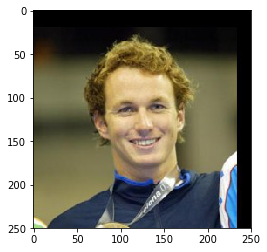

In [157]:
#VGG16_predict_breed('dogImages/test/022.Belgian_tervuren/Belgian_tervuren_01588.jpg')

VGG16_predict_breed('lfw/Aaron_Peirsol/Aaron_Peirsol_0003.jpg')

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [158]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def breed_predictor(img_path):
    isDog = dog_detector(img_path)
    ishuman = face_detector(img_path)
    
    if isDog:
        print("A dog is detected")
        breed = VGG16_predict_breed(img_path)
        return breed
        
    if ishuman:
        print("A human face is detected")
        breed = VGG16_predict_breed(img_path)
        return breed
    
    else:
        
        print("Neither a human face nor a dog is detected")
        img = cv2.imread(img_path)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgplot = plt.imshow(cv_rgb)


---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

A human face is detected
The dog breed resembling this person is Alaskan_malamute


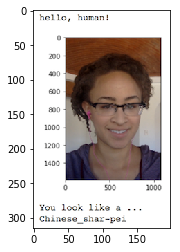

In [159]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

breed_predictor('images/sample_human_output.png')

A dog is detected
This breed for this dog is Labrador_retriever


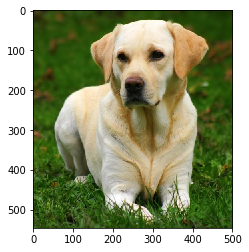

In [160]:
breed_predictor('images/Labrador_retriever_06457.jpg')

Neither a human face nor a dog is detected


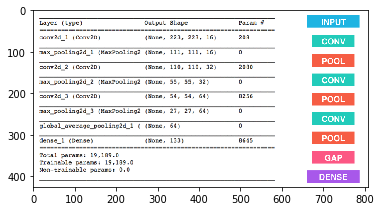

In [123]:
breed_predictor('images/sample_cnn.png')

A human face is detected
The dog breed resembling this person is Beagle


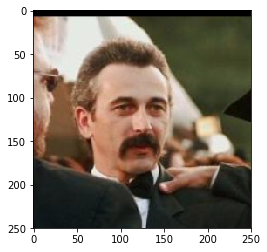

In [125]:
breed_predictor('lfw/Aaron_Tippin/Aaron_Tippin_0001.jpg')

A dog is detected
This breed for this dog is Australian_terrier


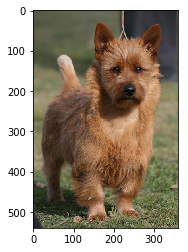

In [161]:
breed_predictor('dogImages/test/013.Australian_terrier/Australian_terrier_00930.jpg')